# Twitter Cyberbullying Text Classification



We will work with a dataset from online social media.

One of the biggest problems on the internet today is the presence of negative attitudes towards certain groups based on their ethnicity, gender, religion, or political ideology. In this exercise, we will work with real data, manually labeled, from Kaggle. Originally, each document in the dataset was assigned one of the following categories:

religion

age

ethnicity

gender

other_cyberbullying

not_cyberbullying

The initial objective of the dataset was to train a model capable of detecting the type of hate content present on the internet according to the targeted group. In this case, to simplify the exercise, a load_prepare_data() function has been generated that changes the dataset categories, resulting in 2 final categories with values 1 or 0, indicating whether the tweet contains hate content.

Classification Exercise

Next, we will perform a classification exercise to correctly classify tweets. This will require:
Creating and using data preprocessing functions similar to those seen in class
Applying text vectorization strategies such as:

- TF-IDF
- Word embeddings

### Training and evaluating classification models
The exercise will involve:
- Data Processing and Model Development
- Creating preprocessing functions for text normalization
- Implementing text vectorization techniques
- Training classification models
- Evaluating model performance
Required Steps
- Data preprocessing and normalization:
- Text cleaning
- Tokenization
- Stop word removal
- Lemmatization/stemming
### Text vectorization:
- Using TF-IDF (Term Frequency-Inverse Document Frequency)
- Implementing word embeddings
- Adding additional features like sentiment analysis
### Model training and validation:
- Testing multiple classification algorithms
- Hyperparameter tuning
### Model evaluation and selection
The goal is to develop a robust classification system that can effectively identify and categorize tweets based on their content.




## 0. Imports


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from sklearn.datasets import make_classification
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
import spacy
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
import contractions
from textblob import TextBlob
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy as sp
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import get_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

## 1. corpus obtention
For the obtention of the data, we use the `load_prepare_data()` function.

In [80]:
def load_prepare_data(path):
  """
  Function to load and process data for the exercise.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

In [14]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
dataset = load_prepare_data(path_data)

In [15]:
dataset.sample(5)

tweet_text  cyberbullying
39938  I bet yo father touched you a lot when you wer...              1
3613   Don't let anyone fool ya kids, puking is not a...              0
25052  RT @datnofact: I hate reading the replies to D...              1
45479  My cuz married and made babies with a white gi...              1
47049  “@tayyoung_: FUCK OBAMA, dumb ass nigger” BITC...              1

## 2. Exploratory data analysis

In [16]:
#Function to visualize the first k rows of a dataframe
def visualize_k_rows_df(df, numero_filas, cmap):
  return df.head(numero_filas).style.background_gradient(cmap = cmap)

In [17]:
#Visualize the number of unique records
dataset.nunique()

tweet_text       46017
cyberbullying        2
dtype: int64

In [18]:
#Visualize the first 3 rows of the dataframe
visualize_k_rows_df(dataset.sample(3), 3,'RdBu_r')

In [51]:
#Count the number of documents and columns in our dataset
print('The total dataset is {} documents'.format((len(dataset))))
print('The dataframe has {} columns'.format(dataset.shape[1]))

#Count the number of duplicated and empty documents to remove them
print('The total number of duplicated documents is {}'.format(np.sum(dataset.duplicated(subset ='tweet_text'))))
print("There are {} empty values in the news and {} empty values in the labels in the data".format(np.sum(dataset.isnull())[0],
                                                                                                       np.sum(dataset.isnull())[1]))
#Remove only the duplicated values of the tweet_text column
dataset2 = dataset.drop_duplicates(subset = 'tweet_text')
print('The total number of documents after removing duplicates is {}'.format(len(dataset2)))
print('The number of duplicated documents is {}'.format(np.sum(dataset2.duplicated(subset='tweet_text'))))

The total dataset is 47692 documents
The dataframe has 2 columns
The total number of duplicated documents is 1675
There are 0 empty values in the news and 0 empty values in the labels in the data
The total number of documents after removing duplicates is 46017
The number of duplicated documents is 0


/Users/Camilo/Documents/tfm/TFM_inmobiliario__/tfm_ev/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/1872899022.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/1872899022.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [20]:
#Count the number of elements in each class
dataset2.groupby(['cyberbullying']).count()

tweet_text
cyberbullying            
0                    7937
1                   38080

In [52]:
#Visualization of data
labels = dataset2['cyberbullying'].value_counts()
fig = px.bar(labels, title = 'Count of values var. cyberbullying')
fig.show()

We observe the clear imbalance between the categories of the cyberbullying variable. On one side, there are approximately 38,000 documents classified as cyberbullying, while there are 7,937 documents of no cyberbullying. This is a problem when training models based on feature engineering techniques. Therefore, later we will manage this imbalance.

In [22]:
#Distribution of lengths.
dataset2["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))
dataset2.sample(3)

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/1270329944.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



tweet_text  cyberbullying  \
41570  fuck muslims im glad they getting it they need...              1   
3218   @dylanw that's cool. next time when a woman ta...              0   
9036   Go fuck yourself Kat, stupid slut #MKR #nofuck...              1   

       char_len  
41570       140  
3218        137  
9036         52

In [23]:
    #Creamos nuestro histograma con la libreria plotly
fig = px.histogram(dataset2, x="char_len", color="cyberbullying", marginal="rug", barmode="overlay", histnorm='probability density')

    # Establecemos el título de los ejes
fig.update_layout(
    xaxis_title="Caracteres",
    yaxis_title="Densidad"
)

# Finally show the graph:
fig.show()

In [24]:
 #Get the index of the text with the highest length
indice_texto_max_longitud = dataset2["char_len"].idxmax()

print("index of the text with the highest length:", indice_texto_max_longitud)

Índice del texto con la mayor longitud: 29205


In [53]:
pd.DataFrame(dataset2.loc[29205])

29205
tweet_text     is feminazi an actual word with a denot…\r\n@N...
cyberbullying                                                  1

In [26]:
indice_texto_max = dataset2["char_len"].idxmax()
# Get the document with the highest length
texto_max_longitud = dataset.loc[indice_texto_max, "tweet_text"]

print("Document with the highest length:")
print(texto_max_longitud)

Documento con la mayor longitud:
is feminazi an actual word with a denot…
@Nasharchy my job means protecting people. even the people i don't agree with/like.
They barely cooked anything on that entrée #MKR
RT @kf: Like, no. If a community fostering jerks prevents users from adopting that community's code, it is very much a technical problem.
It's almost time. :)
@JamesGweenwood shock youre bullying me again.
@LionLionEatEat yeah, someone DMed me a screenshot. meh. let her. i have no idea who she even is.
For more egregious cases for harassment, we definitely need to be able to respond to those appropriately. But most toxicity isn't this.
So, this happened. http://t.co/ZPTRtsYFiV
@Nibelsnarfabarf @srhbutts @GRIMACHU it is really funny all the assumptions they make about how it works - and how much they are wrong.
The lack of self-awareness from @wadhwa right now is staggering and hilarious. #stopwadhwa2015
Hahahaha http://t.co/JRPkJCNVH9
This is going to be a better finale than how I me

We observe that the document with the highest length, composed of 5018 characters, has been incorrectly stored. It appears to be a document composed of different tweets that we can see that deals with both cyberbullying and other topics such as a cooking reality show, 'MKR'.
Therefore, the other outliers we observed in the histogram will also have the same problem. In addition, the maximum number of tweets allowed by Twitter or X is 280, so we can confirm the presence of tweets mixed and incorrectly classified that are being stored as outliers in our histogram of character length.

In this point we will opt to separate these records that we know have been incorrectly classified from the valid records, with less than 280 characters.


In [27]:
long_tweet = dataset2['char_len']>280
valid_tweet = dataset2['char_len']<=280
#split the data into two datasets based on the length of the tweets < 280 characters
ds = dataset2[valid_tweet].copy()
ds_long = dataset2[long_tweet].copy()

In [28]:
#Observe the number of valid records we have left for each category
ds.groupby(['cyberbullying']).count()

tweet_text  char_len
cyberbullying                      
0                    7934      7934
1                   37380     37380

In [29]:
#Observe the histogram of the character length of the clean dataset
fig2 = px.histogram(ds, x="char_len", color="cyberbullying", marginal="rug", barmode="overlay", histnorm='probability density')

# Set the title of the axes
fig2.update_layout(
    xaxis_title="Number of characters",
    yaxis_title="Density"
)

# Finally show the graph:
fig2.show()

We observe that the tweets related to cyberbullying have a longer length than those that are not related.

In [30]:
txt_nobully = ",".join(ds[dataset.cyberbullying==0].tweet_text.to_list())
txt_bully = ",".join(ds[dataset.cyberbullying==1].tweet_text.to_list())
#Define the stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
en_stopwords = stopwords.words('english')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/2776301347.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/2776301347.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Camilo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Wordcloud no relacionado con bullying 



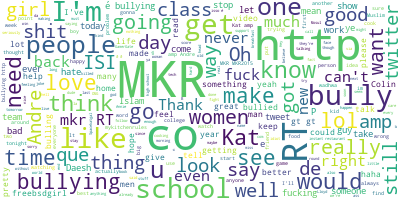

In [31]:
print('Wordcloud no related to bullying \n')
# Generate the wordcloud of the texts not related to bullying
wordcloud.generate(txt_nobully)
# Visualize it in an image
wordcloud.to_image()

Wordcloud relacionado con bullying 



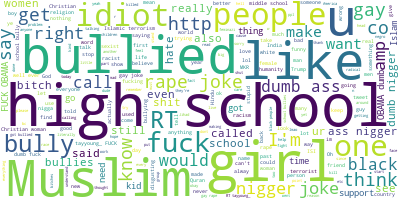

In [32]:
print('Wordcloud related to bullying \n')
# Generate the wordcloud of the texts related to bullying
wordcloud.generate(txt_bully)
# Visualize it in an image
wordcloud.to_image()

Word Cloud Analysis Results
After observing the most frequently used words in both word clouds, we can note the following patterns:
Non-Bullying Word Cloud
High presence of URLs, evidenced by the frequent appearance of 'http'
Frequent mention of 'MKR' (referring to a cooking reality show)
The word 'bully' appears but likely in a context of positive discussion about the topic
Cyberbullying Word Cloud
Key observations:
High presence of insults and offensive language:

- 'idiot'
- 'fuck'
- 'dumb ass'
References to targeted groups:
- 'muslim'
- 'girl'
- 'black'
- 'ngger'
- 'women'
- 'gay'

Technical characteristics:
- Lower presence of URLs
- Lower frequency of the word 'http'

This analysis clearly shows the distinct linguistic patterns between cyberbullying and non-bullying content in the dataset.


In [33]:
#Visualize the first  rows of the dataframe
ds.head()

tweet_text  cyberbullying  char_len
0  In other words #katandandre, your food was cra...              0        61
1  Why is #aussietv so white? #MKR #theblock #ImA...              0       115
2  @XochitlSuckkks a classy whore? Or more red ve...              0        60
3  @Jason_Gio meh. :P  thanks for the heads up, b...              0       103
4  @RudhoeEnglish This is an ISIS account pretend...              0       103

## 3. Preprocessing and Normalization

In [34]:
# Eliminate spaces
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

In [35]:
# Spaces
ds["normalized"] = ds["tweet_text"].apply(lambda x: eliminar_espacios(x))
ds["normalized"] = ds["normalized"].apply(lambda x: texto_to_lower(x))

In [36]:
# replace contractions using the "contractions" library https://github.com/kootenpv/contractions
def replace_contraction(text):
    return contractions.fix(text, slang=True)

In [37]:
ds["normalized"] = ds["normalized"].apply(lambda x: replace_contraction(x))

In [54]:
# Tokenize  
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalize_tokens(document):
    # Split the document into words
    words = tweet_tokenizer.tokenize(document)

    # Replace URLs, Twitter mentions, and numbers with corresponding tokens
    for i in range(len(words)):
        if words[i].startswith("http://") or words[i].startswith("https://") or words[i].startswith("www."):
            words[i] = "URL"
        elif words[i].isdigit():
            words[i] = "NUM"

    # Join the words back into a modified document
    modified_document = ' '.join(words)

    return modified_document

In [39]:
# Normalize tokens
ds["normalized"] = ds["normalized"].apply(lambda x: normalize_tokens(x))

In [42]:
import spacy
# Load the spacy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatize and remove tokens
def lematize_token_removal(text):
    # Process the text with the nlp object
    doc = nlp(text)

    # Lematize the text
    lemmas = [token.lemma_ for token in doc]

    # Remove punctuation and stopwords
    filtered_tokens = [token for token in lemmas if token.isalpha() and token.lower() not in en_stopwords]

    # Join the filtered tokens into a new text
    processed_text = ' '.join(filtered_tokens)

    return processed_text

In [47]:
#Lemmatize and remove tokens
ds["preprocessed_text"] = ds["normalized"].apply(lambda x: lematize_token_removal(x))

In [48]:
ds.sample(3)

tweet_text  cyberbullying  \
1359   @waffle_gurl And you know it's not true becaus...              0   
877    @theThuggie what the HELL were you thinking wi...              0   
37290  New theory: Epstein killed himself but it’s on...              1   

       char_len                                         normalized  \
1359        120  @waffle_gurl and you know it is not true becau...   
877          69  @thethuggie what the hell were you thinking wi...   
37290       126  new theory : epstein killed himself but it is ...   

                                       preprocessed_text  
1359          know true like call muslima video liar bye  
877                              hell think company name  
37290  new theory epstein kill NUM year old high scho...

In [55]:
# Word Cloud Analysis
txt_nobully = ",".join(ds[dataset.cyberbullying==0].preprocessed_text.to_list())
txt_bully = ",".join(ds[dataset.cyberbullying==1].preprocessed_text.to_list())

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/3472439312.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/6l/xmxqxb352dl57_n06gxvgs3m0000gn/T/ipykernel_9188/3472439312.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



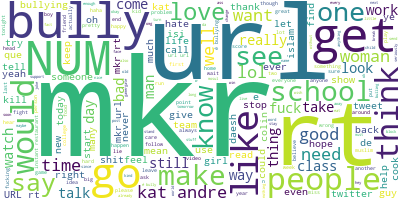

In [56]:
# Generate the new clean wordcloud - No Cyberbullying
wordcloud.generate(txt_nobully)
# Visualize it in an image
wordcloud.to_image()

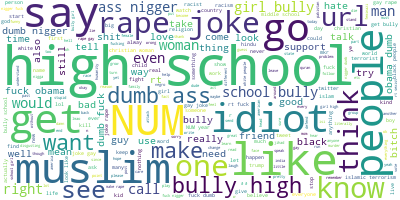

In [57]:
# Generate the new clean wordcloud - Cyberbullying
wordcloud.generate(txt_bully)
# Visualize it in an image
wordcloud.to_image()

## 4. Vectorization

### Sentiment Analysis

In [58]:
ds["sent_subjectivity_str"] = ds["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)
ds["sent_polarity_str"] = ds["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

<Axes: >

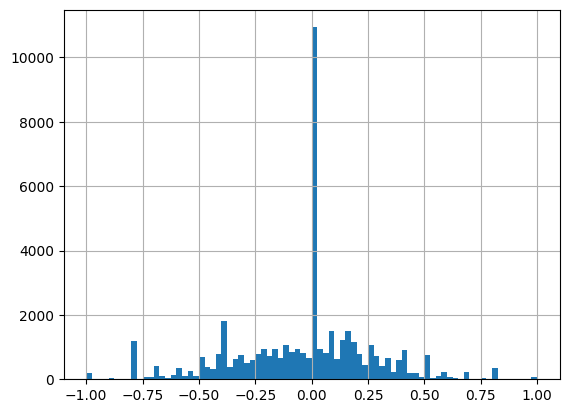

In [59]:
ds["sent_polarity_str"].hist(bins=80)

### Vectorización - TFIDF Vectorizer


In [60]:
vectorizer = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.05, ngram_range = (1,3))

vector_data = vectorizer.fit_transform(ds["preprocessed_text"])

In [61]:
vector_data.shape

(45314, 30)

In [62]:
ds['cyberbullying'].values

array([0, 0, 0, ..., 1, 1, 1])

### Adding additional features - sentiment

In [63]:
extra_features = ds[['sent_subjectivity_str','sent_polarity_str']]
extra_features.shape

(45314, 2)

In [64]:
# Extraemos las etiquetas y las asignamos a la variable y
y = ds["cyberbullying"].values.astype(np.float32)
# Unimos las características TFIDF con las caracteristicas de sentimiento (polaridad y subjetividad)
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

In [65]:
#Check the size of the new concatenated matrix
print(X.shape)

(45314, 32)


In [70]:
#Split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(36251, 32)
(9063, 32)


### Data balancing

In [71]:
smote = SMOTE(random_state=42)
# Retransform the data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [76]:
    # Convert the NumPy array to a Pandas series
y_train_balanced_series = pd.Series(y_train_balanced)
# Create the class balance visualization
y_train_balanced_series = pd.Series(y_train_balanced)
fig = px.bar(y_train_balanced_series.value_counts(), 
             title='Class distribution after applying SMOTE',
             labels={'value': 'Count', 'index': 'Class'},
             color=['No Cyberbullying', 'Cyberbullying'])

# Customize the design
fig.update_layout(
    xaxis_title="Class",
    yaxis_title="Sample count",
    showlegend=False
)
fig.show()

# Show the exact values
print("\nClass distribution after balancing:")
print(y_train_balanced_series.value_counts())


Class distribution after balancing:
1.0    29901
0.0    29901
Name: count, dtype: int64


### SMOTE Balancing Results
After using the SMOTE algorithm from the imbalanced-learn library, we can observe through the bar chart the balancing of this categorical variable in both classes, reaching 29901 samples in each category.

### Key Points:
- Original Data: Imbalanced distribution between cyberbullying and non-cyberbullying classes
- SMOTE Application: Successfully balanced both classes
- Final Distribution: Approximately 29901 samples per class
Result: The dataset is now properly balanced and ready for model training

This balanced dataset will help prevent bias in our model training and should lead to better classification performance for both majority and minority classes.

The model is now ready to be trained with this balanced dataset, which should provide more reliable and unbiased predictions for both cyberbullying and non-cyberbullying content.

## 5. Model training and evaluation

In [89]:
def model_evaluation(models, X_train, y_train, X_test, y_test):
    """
    Evaluación de modelos usando datos de entrenamiento balanceados y test sin balancear
    
    Parameters:
    -----------
    models: list of tuples
        Lista de tuplas (nombre_modelo, modelo)
    X_train: array-like
        Features de entrenamiento balanceados
    y_train: array-like
        Target de entrenamiento balanceado
    X_test: array-like
        Features de test (sin balancear)
    y_test: array-like
        Target de test (sin balancear)
    """
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    results_dict = {}
    
    for name, model in models:
        print(f"\nEvaluando modelo: {name}")
        results_dict[name] = {}
        
        # Cross-validation in balanced training data
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for metric in scoring:
            # Evaluación con cross validation en datos de entrenamiento
            cv_results = cross_val_score(
                model, X_train, y_train, 
                cv=skf, 
                scoring=metric,
                n_jobs=-1
            )
            
            # Entrenar modelo con todos los datos de entrenamiento
            model.fit(X_train, y_train)
            
            # Evaluar en conjunto de test no balanceado
            if metric == 'roc_auc':
                test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
            else:
                test_score = get_scorer(metric)(model, X_test, y_test)
            
            results_dict[name][metric] = {
                'cv_mean': cv_results.mean(),
                'cv_std': cv_results.std(),
                'test_score': test_score
            }
            
            print(f"CV {metric}: {cv_results.mean():.4f} (+/- {cv_results.std() * 2:.4f})")
            print(f"Test {metric}: {test_score:.4f}")
    
    return results_dict

models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
]
results = model_evaluation(models, X_train_balanced, y_train_balanced, X_test, y_test)


Evaluando modelo: Logistic Regression
CV accuracy: 0.8008 (+/- 0.0034)
Test accuracy: 0.7584
CV precision: 0.8486 (+/- 0.0044)
Test precision: 0.9606
CV recall: 0.7324 (+/- 0.0091)
Test recall: 0.7374
CV f1: 0.7862 (+/- 0.0047)
Test f1: 0.8343
CV roc_auc: 0.8641 (+/- 0.0028)
Test roc_auc: 0.8598

Evaluando modelo: Random Forest
CV accuracy: 0.8648 (+/- 0.0051)
Test accuracy: 0.7974
CV precision: 0.9214 (+/- 0.0088)
Test precision: 0.9385
CV recall: 0.7977 (+/- 0.0086)
Test recall: 0.8075
CV f1: 0.8551 (+/- 0.0055)
Test f1: 0.8680
CV roc_auc: 0.9247 (+/- 0.0029)
Test roc_auc: 0.8640


The Random Forest classifier is the recommended choice for this cyberbullying detection task due to its:
Superior performance across all metrics
Better handling of the complexity in text data
More balanced prediction capabilities
Higher reliability in real-world applications
This selection ensures better detection of cyberbullying cases while maintaining a reasonable rate of false positives.

### Optimized Random Forest Model - GridSearchCV

In [92]:
# 1. Definir el modelo base
model = RandomForestClassifier(random_state=42)

# 2. Grid de hiperparámetros más ligero pero efectivo
param_grid = {
    'n_estimators': [100, 200],          # Reducido a 2 opciones
    'max_depth': [10, 20],               # Valores específicos, sin None
    'min_samples_split': [5],            # Valor único
    'max_features': ['sqrt'],            # Solo sqrt
    'class_weight': ['balanced']         # Solo balanced
}

# 3. Métricas más relevantes
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'                          # Reducido a las métricas más importantes
}

# 4. Validación cruzada con menos splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reducido a 3 splits

# 5. GridSearchCV optimizado
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,                          # Usar todos los cores disponibles
    verbose=1,
    return_train_score=False            # No guardar scores de entrenamiento
)

# 6. Ajustar el modelo
print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train_balanced, y_train_balanced)

# 7. Mostrar resultados
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print("\nMejores puntuaciones:")
for metric in scoring.keys():
    print(f"{metric}: {grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]:.4f}")

Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 4 candidates, totalling 12 fits



Mejores parámetros encontrados:
{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Mejores puntuaciones:
accuracy: 0.8444
f1: 0.8247


The optimized Random Forest model shows solid performance with:

Accuracy: 84.44%

F1-score: 82.47%

Best configuration found uses 100 trees with max depth of 20, suggesting a good balance between model complexity and performance. The balanced class weights help handle the cyberbullying detection task effectively while maintaining computational efficiency.
These results indicate strong predictive capability for cyberbullying detection while keeping the model relatively lightweight.

In [94]:
# 1. create the final model
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

# 2. train the final model
final_model.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=5, random_state=42)

In [95]:
# 3. Hacer predicciones en conjunto de test
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.42      0.90      0.57      1584
         1.0       0.97      0.74      0.84      7479

    accuracy                           0.77      9063
   macro avg       0.70      0.82      0.71      9063
weighted avg       0.88      0.77      0.79      9063



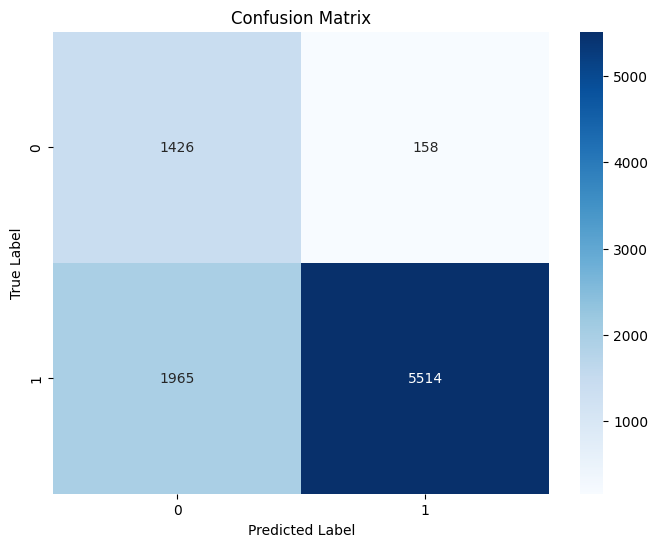

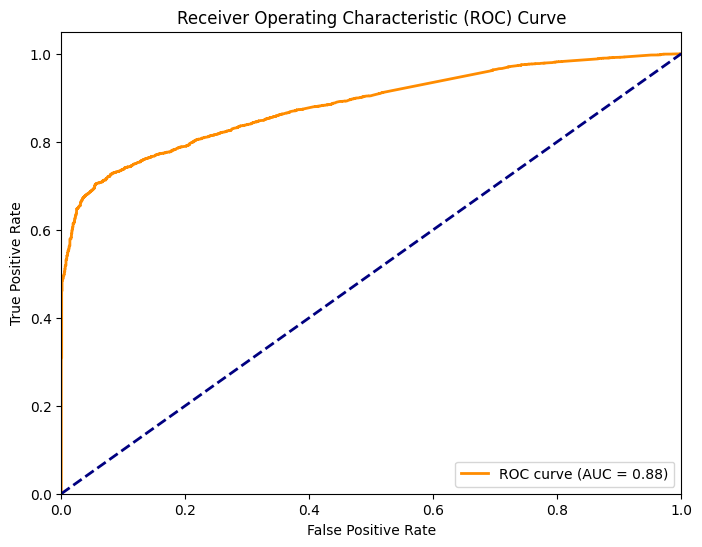

In [96]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Final Model Performance Analysis
### ROC CURVE analysis
The ROC curve shows strong model performance with an AUC (Area Under Curve) of 0.88, indicating:
- Excellent discrimination ability (88% accuracy in ranking positive vs negative cases)
- Strong curve shape, rising sharply at low false positive rates
- Significantly better than random classification (dotted diagonal line)

This high AUC score confirms the model's effectiveness in distinguishing between cyberbullying and non-cyberbullying content, with good balance between sensitivity and specificity.

### Class-wise Performance
Non-cyberbullying (Class 0):
- Precision: 0.42 - Low precision indicates high false positives
- Recall: 0.90 - Excellent detection of non-bullying cases
- F1-score: 0.57 - Moderate overall performance

Cyberbullying (Class 1):
- Precision: 0.97 - Very high precision in detecting bullying
- Recall: 0.74 - Good detection rate of actual bullying cases
- F1-score: 0.84 - Strong overall performance
### Overall Metrics:
- Accuracy: 0.77 (77%) across 9,063 samples
- Macro Average: 0.71 F1-score
- Weighted Average: 0.79 F1-score
### Key Insights:
- The model excels at correctly identifying cyberbullying (97% precision)
- Strong recall (90%) for non-bullying cases
- This model would be particularly useful in applications where high precision in detecting cyberbullying is crucial, though it may generate some false positives for non-bullying content.


